In [1]:
# from mf.mf import godec
import numpy as np
import scipy.io as scio
import matplotlib.pyplot as plt
import copy
from sklearn.metrics import roc_curve, auc
import inspect
from powercase14 import power_env
from config_mea_idx import define_mea_idx_noise
from pypower.api import case14
from pypower.idx_bus import PD, QD
from pypower.idx_brch import RATE_A, BR_X
from gen_data import gen_case, gen_load
# from MTD import mtd
from sklearn import metrics
import MTD

# plt.style.use('fivethirtyeight')
# Plot options
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 6
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'normal'
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams['figure.figsize'] = (5,4)
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams['legend.loc'] = 'lower right'
plt.rcParams['legend.fontsize'] = 14
plt.rcParams['text.usetex'] = True#默认为false，此处设置为TRUE
plt.rcParams['font.family'] = 'Times New Roman'

In [12]:
def dcse_normal(case_env, times, noise_flag):
    # z_sum = []
    r_sum = []

    for i in range(times):
        result = case_env.run_opf(opf_idx = i)
        # print(f'Is {i}th OPF success: {result["success"]}')
        z, z_noise = case_env.construct_mea(result) # Get the measurement 
        if noise_flag > 0:
            z_mea = z_noise
        else:
            z_mea = z
        x_est, z_est, r = case_env.dc_se(z_mea)
        # z_sum.append(z_mea)
        r_sum.append(r)
    return r_sum

def dcse_attack(case_env, times, noise_flag, att_type):
    r_sum = []

    result = case_env.run_opf()
    # print(f'Is OPF success: {result["success"]}')
    z, z_noise = case_env.construct_mea(result) # Get the measurement
    if noise_flag > 0:
        z_mea = z_noise
    else:
        z_mea = z
    
    if att_type == 'single':#single-bus
        za_fdi,a,c = case_env.gen_sin_fdi(z_mea)
    elif att_type == 'unmul': #uncoordiante multiple-bus
        za_fdi,a,c = case_env.gen_mul_fdi(z_mea)
    elif att_type == 'comul': #coordiante multiple-bus
        za_fdi,a,c = case_env.gen_co_fdi(z_mea)

    
    for i in range(times):
        result = case_env.run_opf(opf_idx = i+5)
        # print(f'Is OPF success: {result["success"]}')
        z, z_noise = case_env.construct_mea(result) # Get the measurement
        if noise_flag > 0:
            z_mea = z_noise
        else:
            z_mea = z
        
        a = case_env.H@c
        za_fdi = np.add(z_noise,a.reshape(53,1))
       
        x_est, z_est, r = case_env.dc_se(za_fdi)
        # za_sum.append(za_fdi)
        r_sum.append(r)
    return r_sum, c

def perturb_strategy(env, c):
    att_bus = []
    for i in range(len(c)):
        if c[i] != 0:
            # att_bus.append(i)
            att_bus.append(env.non_ref_index[i])


    brh = [i for i in range(env.no_brh)]
    pertub_brh = []
    flag = 0

    for i in range(env.no_brh):
        if env.f_bus[i] in att_bus and env.t_bus[i] in att_bus:
            brh.pop(flag)
        elif env.f_bus[i] == env.ref_index or env.t_bus[i] == env.ref_index:
            brh.pop(flag)
        else:
            flag = flag + 1
    # print(brh)
    for i in brh:
        if env.f_bus[i] in att_bus:
            if c[env.non_ref_index.index(env.f_bus[i])] !=2:
                pertub_brh.append(i)
            att_bus.remove(env.f_bus[i])
        elif env.t_bus[i] in att_bus:
            if c[env.non_ref_index.index(env.t_bus[i])] !=2:
                pertub_brh.append(i)
            att_bus.remove(env.t_bus[i])
    return pertub_brh
    
def dcse_mtd(case_env, times, c):
    # z_sum = []
    r_sum = []

    for i in range(times):
        # pos = np.argmax(c)
        # attack_bus = case_env.non_ref_index[pos]
        brh = perturb_strategy(case_env, c)
        # for i in range(case_env.no_brh): # Find the branch connected to the attacked bus
        #     f = case_env.f_bus[i]
        #     t = case_env.t_bus[i]
        #     if f==attack_bus or t==attack_bus:
        #         brh = i
        #         break
        se, r_mtd,_,_,_ = case_env.se_mtd(c,brh)

        r = r_mtd/2
        print(r)
        # if r<200:
        #     r_sum.append(r)
        # else:
        #     r_sum.append(r)
        r_sum.append(r)
        # se, r_mtd = case_env.se_mtd(c,4)
    return r_sum

In [3]:
# Instance power env
case_name = 'case14'
case = case14()
case = gen_case(case, 'case14')
mea_idx, no_mea, noise_sigma = define_mea_idx_noise(case, 'FULL')
_, _ = gen_load(case, 'case14')
case_env = power_env(case = case, case_name = case_name, noise_sigma = noise_sigma, idx = mea_idx, fpr = 0.05)

case_name_test = 'case14'
case_test = case14()
case_test = gen_case(case_test, 'case14')  # Modify the case
mea_idx_test, no_mea_test, noise_sigma_test = define_mea_idx_noise(case_test, 'FULL')
_, _ = gen_load(case_test, 'case14')
case_env_test = power_env(case = case_test, case_name = case_name_test, noise_sigma = noise_sigma_test, idx = mea_idx_test, fpr = 0.05)

Load file found, loading the data...
Run on the default load condition.
Initial OPF tests ok.
************************************************************
Load file found, loading the data...
Run on the default load condition.
Initial OPF tests ok.
************************************************************


In [28]:
noise_flag = 5
att_type = 'single'
att_times = 5

R2 = []
r_normal = dcse_normal(case_env_test, 20, noise_flag)
R2.extend(r_normal)
r_fdi, c_fdi= dcse_attack(case_env, 1, noise_flag, att_type)
R2.extend(r_fdi)
r_mtd1 = dcse_mtd(case_env, 1, c_fdi)
R2.extend(r_mtd1)
r_normal1 = dcse_normal(case_env_test, 1, noise_flag)
R2.extend(r_normal1)
r_mtd2 = dcse_mtd(case_env, 2, c_fdi)
R2.extend(r_mtd2)
r_normal2 = dcse_normal(case_env_test, 10, noise_flag)
R2.extend(r_normal2)

Run on the default load condition.
443.9166809874717
151.93275147121167
121.38408369103662


In [14]:
R1 = []
r_normal = dcse_normal(case_env_test, 20, noise_flag)
R1.extend(r_normal)
r_fdi, c_fdi= dcse_attack(case_env, 1, noise_flag, att_type)
R1.extend(r_fdi)
r_mtd = dcse_mtd(case_env, 4, c_fdi)
R1.extend(r_mtd)
r_normal2 = dcse_normal(case_env_test, 10, noise_flag)
R1.extend(r_normal2)

Run on the default load condition.
284.69440571685783
184.9099450698516
142.30677206299342
259.6663381901711


In [22]:
R3 = []
r_normal = dcse_normal(case_env_test, 20, noise_flag)
R3.extend(r_normal)
r_fdi, c_fdi= dcse_attack(case_env, 1, noise_flag, att_type)
R3.extend(r_fdi)
r_mtd = dcse_mtd(case_env, 4, c_fdi)
R3.extend(r_mtd)
r_normal2 = dcse_normal(case_env_test, 10, noise_flag)
R3.extend(r_normal2)

Run on the default load condition.
140.42975930778374
233.48145914237642
183.0647927017279
288.6102234155708


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


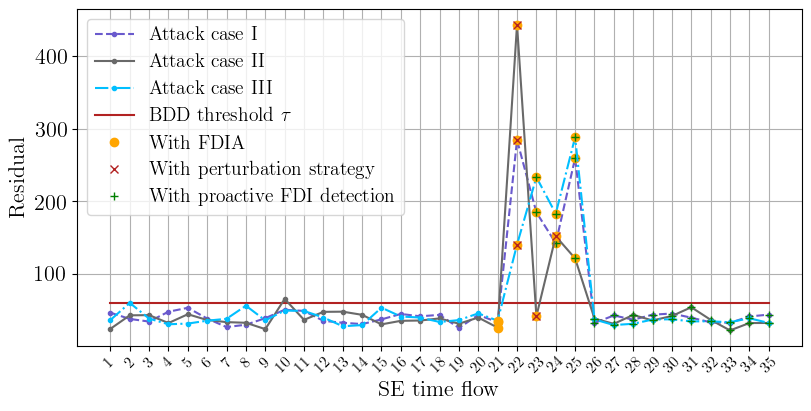

In [44]:
# R = np.array(R).reshape([20,1]) 
# print(R1)
x1=np.arange(1,36)
x2=np.arange(21,26)
x3 = np.arange(22,23)
x4 = np.arange(23,36)
x5 = np.arange(22,25)
x6 = np.arange(25,36)

tau = [case_env_test.bdd_threshold+4]*35

plt.figure(figsize=(8, 4))
l1, =plt.plot(x1,R1,'--', color='slateblue', marker='.')
l2, =plt.plot(x1,tau,'-', color='firebrick')
l3, =plt.plot(x2,R1[20:25],'o', color='orange')
l4, =plt.plot(x3,R1[21:22],'x', color='firebrick')
l13, =plt.plot(x4,R1[22:35],'+', color='g')


l5, =plt.plot(x1,R2,'-', color='dimgrey', marker='.')
# l6, =plt.plot(x1,tau,'r-',label='type1')
l7, =plt.plot(x2,R2[20:25],'o', color='orange')
l8, =plt.plot(x5,R2[21:24],'x', color='firebrick')
l14, =plt.plot(x6,R2[24:35],'+', color='g')

l9, =plt.plot(x1,R3,'-.', color='deepskyblue', marker='.')
# l10, =plt.plot(x1,tau,'r-',label='type1')
l11, =plt.plot(x2,R3[20:25],'o', color='orange')
l12, =plt.plot(x3,R3[21:22],'x', color='firebrick')
l15, =plt.plot(x4,R3[22:35],'+', color='g')

# plt.title('The Lasers in Three Conditions')
plt.xlabel('SE time flow')
plt.ylabel('Residual')

plt.grid()


xt = [0,21,22,26,30]
# xlabel = np.linspace(-0.1,0.1, 3)
plt.xticks(x1,rotation=45,fontsize=11)
plt.legend(handles=[l1,l5,l9,l2,l3,l4,l13],labels=['Attack case I','Attack case II','Attack case III',r'BDD threshold $\tau$',
                                                   'With FDIA','With perturbation strategy','With proactive FDI detection'],
           loc ='upper left')

# ax.set_xticklabels(x)
# plt.show()
plt.savefig("E:\\MY\\paper\\FDILocation\\code\\pic\\CDF\\0801\\residual.eps", dpi=600)